# FVT model

## Model

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp
import time

def solve_permeation_pde(beta=2.0, eta=0.1, D0=1e-7, L=0.1, T=1000.0, dx=0.01,
                            rtol=1e-8, atol=1e-10, verbose=True, display_plot=True):
    """
    Solves the permeation PDE with time in seconds:
    (∂C_tilde / ∂t) = (D0 / L^2) * ∂/∂x_tilde [ D_tilde(C_tilde) * (∂C_tilde / ∂x_tilde) ]
    
    Parameters:
    -----------
    beta : float
        Parameter in dimensionless diffusivity formula
    eta : float
        Parameter in dimensionless diffusivity formula
    D0 : float
        Characteristic diffusivity (cm²/s)
    L : float
        Membrane thickness (cm)
    T : float
        Total simulation time (s)
    dx : float
        Spatial step size (dimensionless)
    rtol : float
        Relative tolerance for solver
    atol : float
        Absolute tolerance for solver
    verbose : bool
        Whether to display status messages during calculation (default: True)
    display_plot : bool
        Whether to display plots or not (default: True)
    
    Returns:
    --------
    C_df : DataFrame
        Concentration profiles at each time point
    flux_df : DataFrame
        Normalized flux over time
    solution : object
        Solution object from solve_ivp
    C_ss : ndarray
        Steady-state concentration profile
    J_ss : float
        Steady-state flux
    """
    # Discretize space
    X = 1.0  # Dimensionless length
    Nx = int(X / dx) + 1
    x = np.linspace(0, X, Nx)
    
    # Time scaling factor for conversion between t and t_tilde
    time_factor = D0 / L**2
    
    # Define dimensionless diffusivity function
    def D_tilde(C):
        return np.exp(-beta / (1 + eta * C))
    
    # Define the ODE system derived from Method of Lines
    def diffusion_ode(t, C):
        """Convert PDE to system of ODEs using Method of Lines"""
        dCdt = np.zeros_like(C)
        
        # Apply boundary conditions first
        # Fixed Dirichlet boundary conditions
        dCdt[0] = 0  # C_tilde(0, t) = 1 (handled in initial conditions)
        dCdt[-1] = 0  # C_tilde(1, t) = 0 (handled in initial conditions)
        
        # Interior points
        for i in range(1, len(C)-1):
            # Calculate diffusivity at midpoints
            D_i_plus_half = 0.5 * (D_tilde(C[i]) + D_tilde(C[i+1]))
            D_i_minus_half = 0.5 * (D_tilde(C[i-1]) + D_tilde(C[i]))
            
            # Calculate spatial derivatives
            dC_dx_plus = (C[i+1] - C[i]) / dx
            dC_dx_minus = (C[i] - C[i-1]) / dx
            
            # Flux at i+1/2 and i-1/2
            J_plus = -D_i_plus_half * dC_dx_plus
            J_minus = -D_i_minus_half * dC_dx_minus
            
            # Rate of change = - divergence of flux
            # Apply the scaling factor time_factor here
            dCdt[i] = time_factor * (-(J_plus - J_minus) / dx)
        
        return dCdt
    
    # Initial condition: C_tilde(x_tilde, 0) = 0 for all x_tilde in [0, 1]
    C0 = np.zeros(Nx)
    
    # Apply boundary conditions to initial state
    C0[0] = 1.0  # C_tilde(0, t) = 1
    C0[-1] = 0.0  # C_tilde(1, t) = 0
    
    # Track solution timing
    start_time = time.time()
    
    # Solve using solve_ivp with BDF method (good for stiff problems)
    if verbose:
        print("Starting solve_ivp integration...")
        print(f"Simulating {T} seconds with thickness {L:.0f} cm and D0={D0:.2e} cm²/s")
    
    solution = solve_ivp(
        diffusion_ode, 
        t_span=[0, T],
        y0=C0,
        method='BDF',  # Backward Differentiation Formula (for stiff problems)
        rtol=rtol,
        atol=atol,
        first_step=1e-4,  # Suggested initial step
        max_step=T/100,  # Maximum allowed step
        dense_output=True  # Allow interpolation for output
    )
    
    end_time = time.time()
    solve_time = end_time - start_time
    if verbose:
        print(f"Integration complete. Time taken: {solve_time:.4f} seconds")
    
    # Calculate characteristic time
    tau = 1/time_factor
    if verbose:
        print(f"Characteristic diffusion time: {tau:.2f} seconds")
    
    # Extract sample points for output
    # t_eval = np.linspace(0, T, 10)  # 10 time spaces
    t_eval = np.arange(0, T, 10)  # time step = 10
    C_history = []
    
    for t in t_eval:
        C_t = solution.sol(t)  # Evaluate solution at time t using the interpolation function
        C_history.append(C_t)  # Add the concentration profile at time t to the history
    
    C_arr = np.array(C_history)
    
    # Calculate time-dependent flux
    J_t = np.zeros(len(t_eval))
    
    for i, t in enumerate(t_eval):
        # Use second-order one-sided finite difference at the boundary
        # f'(x_n) ≈ (3f(x_n) - 4f(x_{n-1}) + f(x_{n-2}))/(2h)
        C_n = C_arr[i, -1]
        C_nm1 = C_arr[i, -2]
        C_nm2 = C_arr[i, -3]
        dC_dx_boundary = (3*C_n - 4*C_nm1 + C_nm2) / (2*dx)
        
        # Calculate flux using the diffusivity at the boundary
        J_t[i] = -D_tilde(C_n) * dC_dx_boundary
    
    # Solve for steady-state solution explicitly
    # At steady state, the flux is constant across the membrane
    # Meaning: D(C) * dC/dx = constant
    if verbose:
        print("Calculating steady-state solution...")
    
    # Create a fine mesh for accurate steady-state solution
    Nx_fine = 1001
    x_fine = np.linspace(0, 1, Nx_fine)
    dx_fine = 1.0 / (Nx_fine - 1)
    
    # Use a shooting method to find the steady-state solution
    def steady_state_ode(x, y):
        # y[0] = C, y[1] = J (flux, which is constant in steady state)
        dydx = np.zeros(2)
        # dC/dx = -J / D(C)
        dydx[0] = -y[1] / D_tilde(y[0])
        dydx[1] = 0  # Flux is constant in steady state
        return dydx
    
    # Use scipy's solve_ivp for the shooting method
    from scipy.optimize import root_scalar
    
    def shoot(J_guess):
        # Integrate from x=0 to x=1 with the guessed flux
        # Initial condition: C(0) = 1, flux = J_guess
        y0 = [1.0, J_guess]
        
        solution_ss = solve_ivp(
            steady_state_ode,
            [0, 1],
            y0,
            method='RK45',
            rtol=1e-10,
            atol=1e-12,
            dense_output=True
        )
        
        # Evaluate at x=1 and check if C(1) = 0
        C_end = solution_ss.sol(1.0)[0]
        return C_end  # We want this to be 0
    
    # Find the flux that gives C(1) = 0
    result = root_scalar(shoot, bracket=[1e-6, 10.0], method='brentq')
    J_ss = result.root
    
    # Get the steady-state solution with the correct flux
    y0_ss = [1.0, J_ss]
    solution_ss = solve_ivp(
        steady_state_ode,
        [0, 1],
        y0_ss,
        method='RK45',
        rtol=1e-10,
        atol=1e-12,
        dense_output=True
    )
    
    # Extract steady-state concentration profile
    C_ss = np.zeros(Nx_fine)
    for i, xi in enumerate(x_fine):
        C_ss[i] = solution_ss.sol(xi)[0]
    
    if verbose:
        print(f"Steady-state flux calculated: {J_ss:.6e}")
    
    # Normalize the time-dependent flux
    J_norm = J_t / J_ss
    
    # Calculate time to reach 99% of steady state
    idx_99 = np.where(J_norm >= 0.99)[0]
    if len(idx_99) > 0:
        t_99 = t_eval[idx_99[0]]
        if verbose:
            print(f"Time to reach 99% of steady state: {t_99:.2f} seconds ({t_99/tau:.2f} τ)")
    else:
        if verbose:
            print("Simulation didn't reach 99% of steady state within the time range.")
    
    # Create DataFrames for output
    C_df = pd.DataFrame(C_arr, columns=[f"x={xi:.3f}" for xi in x], index=t_eval)
    flux_df = pd.DataFrame({
        "time (s)": t_eval,
        "normalized_flux": J_norm,
        "dimensionless_time (t/τ)": t_eval / tau
    })
    
    # Create plots
    if display_plot:
        # Basic plotting
        plt.figure(figsize=(12, 12))
        
        # Plot concentration profiles
        plt.subplot(3, 1, 1)
        plt.plot(x, C_arr[-1, :], 'b-', linewidth=2, label=f'Final state (t={T:.1f} s)')
        plt.plot(x_fine, C_ss, 'k--', linewidth=2, label='Steady state')
        plt.plot(x, C_arr[0, :], 'r--', label='Initial state (t=0 s)')
        for i in range(1, 5):
            idx = i * len(t_eval) // 10
            if idx < len(t_eval):
                plt.plot(x, C_arr[idx, :], '--', label=f't={t_eval[idx]:.1f} s')
        plt.xlabel('Dimensionless position (x_tilde)')
        plt.ylabel("Dimensionless concentration (C_tilde)")
        plt.title(f"Concentration Profile Evolution (β={beta}, η={eta})")
        plt.legend()
        plt.grid(True)
        
        # Plot normalized flux vs real time
        plt.subplot(3, 1, 2)
        plt.plot(t_eval, J_norm, 'g-', linewidth=2)
        plt.xlabel('Time (s)')
        plt.ylabel('Normalized Flux (J(t)/J_ss)')
        plt.title('Flux Evolution vs Time')
        plt.axhline(y=1.0, color='k', linestyle='--', label='Steady state')
        if len(idx_99) > 0:
            plt.axvline(x=t_99, color='r', linestyle=':', label=f'99% steady state ({t_99:.1f} s)')
        plt.grid(True)
        plt.legend()
        
        # Plot normalized flux vs dimensionless time
        plt.subplot(3, 1, 3)
        plt.plot(t_eval/tau, J_norm, 'b-', linewidth=2)
        plt.xlabel('Dimensionless time (t/τ)')
        plt.ylabel('Normalized Flux (J(t)/J_ss)')
        plt.title('Flux Evolution vs Dimensionless Time')
        plt.axhline(y=1.0, color='k', linestyle='--', label='Steady state')
        if len(idx_99) > 0:
            plt.axvline(x=t_99/tau, color='r', linestyle=':', label=f'99% steady state ({t_99/tau:.2f} τ)')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Solver statistics
        if verbose:
            print(f"Number of function evaluations: {solution.nfev}")
            print(f"Number of Jacobian evaluations: {solution.njev}")
            print(f"Solver status: {solution.status}")
            print(f"Number of successful steps: {solution.nfev // (solution.njev + 1)}")  # Approximate
            print(f"Solve time: {solve_time:.4f} seconds")
    
    # Create a dictionary with key results for easy access
    results = {
        "steady_state_flux": J_ss,
        "characteristic_time": tau,
        "time_to_99_percent": t_99 if len(idx_99) > 0 else None,
        "dimensionless_time_to_99_percent": t_99/tau if len(idx_99) > 0 else None,
        "beta": beta,
        "eta": eta,
        "D0": D0,
        "L": L
    }
    
    return C_df, flux_df, solution, C_ss, J_ss, results

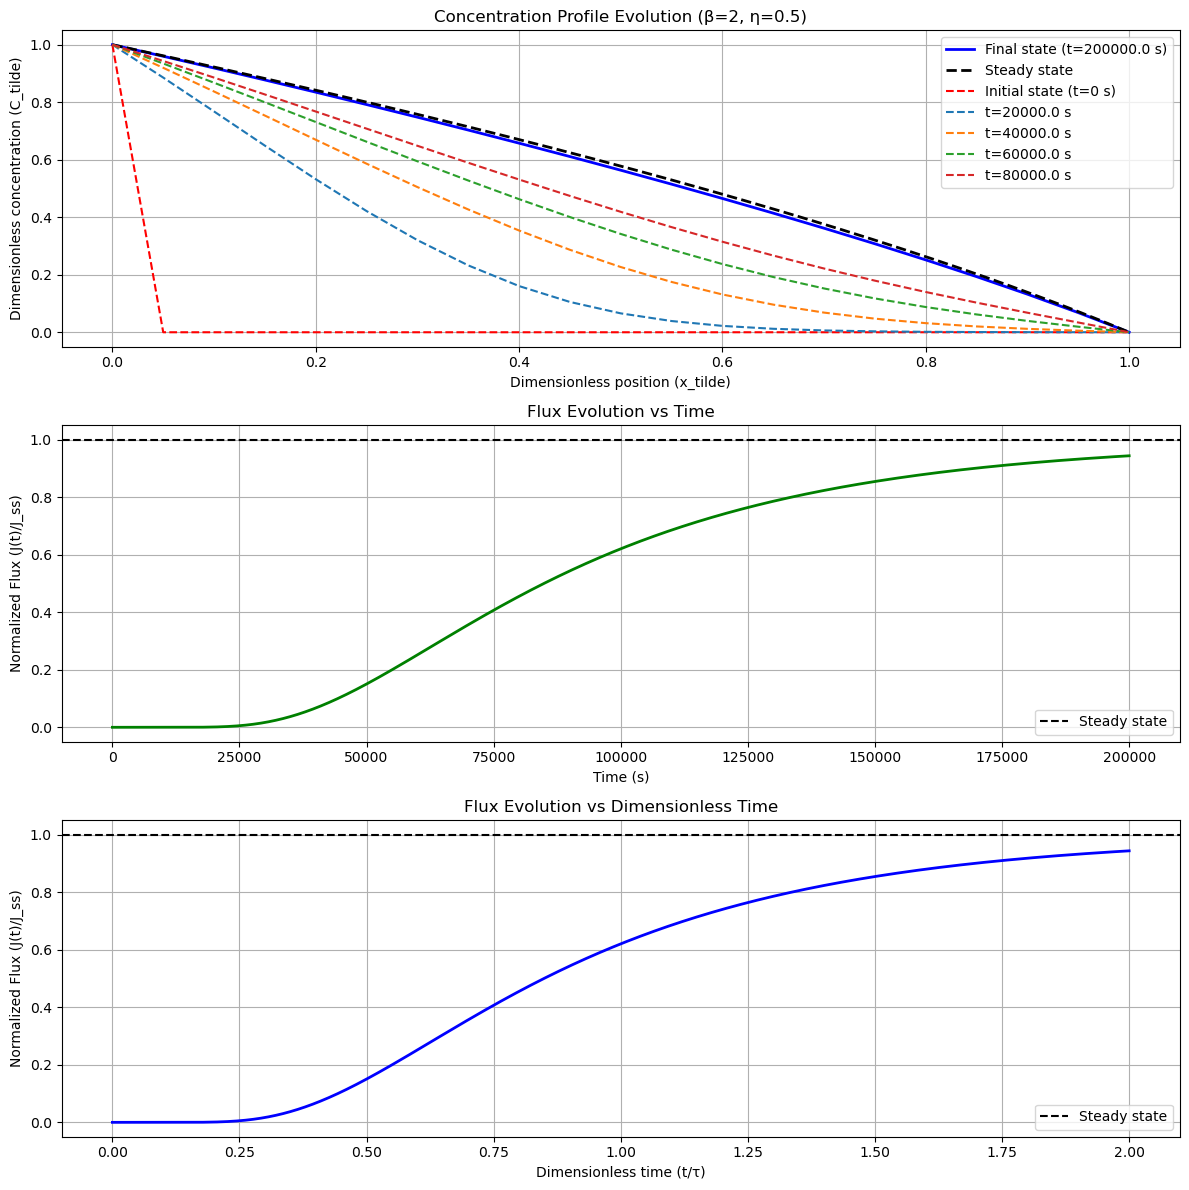

In [22]:
C_df, flux_df, solution, C_ss, J_ss, results = solve_permeation_pde(beta=2, eta=0.5, D0=1e-7, L=0.1, T=200e3, dx=0.05, verbose=False, display_plot=True)

## Fitting

In [23]:
def fit_permeation_parameters(time, normalised_flux, L=0.1, initial_guesses=None, bounds=None, max_iter=50, max_trials=3):
    """
    Fits beta, eta, and D0 parameters to experimental permeation data with multiple starting points.
    
    Parameters:
    -----------
    time : array-like
        Time values of experimental data (seconds)
    normalised_flux : array-like
        Normalised flux values (J(t)/J_ss) of experimental data
    L : float
        Membrane thickness (cm), default 0.1 cm
    initial_guesses : list of dict or dict, optional
        List of initial guesses for parameters [{'beta': value, 'eta': value, 'D0': value}, ...]
        If a single dict is provided, it will be used as the only starting point
        If None, default values will be used
    bounds : dict, optional
        Parameter bounds {'beta': (min, max), 'eta': (min, max), 'D0': (min, max)}
        If None, default bounds will be used
    max_iter : int
        Maximum number of iterations for each optimization
    max_trials : int
        Maximum number of different starting points to try (used only if initial_guesses is None)
        
    Returns:
    --------
    best_params : dict
        Best-fit parameters {'beta': value, 'eta': value, 'D0': value}
    fit_results : dict
        Detailed results including error metrics and fitted data
    """
    from scipy.optimize import minimize
    from scipy.interpolate import interp1d
    import numpy as np
    import time as time_module
    
    # Convert inputs to numpy arrays if they aren't already
    exp_time = np.array(time)
    exp_flux = np.array(normalised_flux)
    
    # Default bounds if not provided
    if bounds is None:
        bounds = {
            'beta': (0.1, 10.0),
            'eta': (0.01, 5.0),
            'D0': (1e-9, 1e-5)
        }
    
    # Process initial guesses
    if initial_guesses is None:
        # Generate multiple starting points
        initial_guesses = [
            {'beta': 2.0, 'eta': 0.1, 'D0': 1e-7},
            {'beta': 1.0, 'eta': 0.5, 'D0': 5e-7},
            {'beta': 5.0, 'eta': 0.01, 'D0': 1e-6}
        ][:max_trials]  # Use up to max_trials default starting points
    elif isinstance(initial_guesses, dict):
        # Convert single dict to list
        initial_guesses = [initial_guesses]
    
    # Convert bounds to format needed by scipy.optimize.minimize
    param_bounds = [(bounds['beta'][0], bounds['beta'][1]), 
                   (bounds['eta'][0], bounds['eta'][1]), 
                   (bounds['D0'][0], bounds['D0'][1])]
    
    # Maximum simulation time (slightly beyond the experimental time range)
    T_max = 1.2 * np.max(exp_time)
    
    # Define objective function (sum of squared errors)
    def objective_function(params):
        beta, eta, D0 = params
        
        try:
            # Run simulation with current parameters
            _, flux_df, _, _, _, results = solve_permeation_pde(
                beta=beta, 
                eta=eta, 
                D0=D0, 
                L=L, 
                T=T_max, 
                dx=0.05,    #* Faster simulation
                verbose=False,
                display_plot=False
            )
            
            # Create interpolator for model flux data
            model_time = flux_df['time (s)'].values
            model_flux = flux_df['normalized_flux'].values
            
            # Check if simulation covers the experimental time range
            if np.max(model_time) < np.max(exp_time):
                print(f"Warning: Simulation time ({np.max(model_time):.2f} s) doesn't cover experimental time range ({np.max(exp_time):.2f} s)")
                # Return a high error
                return 1e6
            
            # Create interpolation function for model data
            flux_interp = interp1d(model_time, model_flux, kind='cubic', bounds_error=False, fill_value="extrapolate")
            
            # Calculate model flux at experimental time points
            model_flux_at_exp_times = flux_interp(exp_time)
            
            # Calculate sum of squared errors
            sse = np.sum((model_flux_at_exp_times - exp_flux)**2)
            
            # Calculate root mean squared error
            rmse = np.sqrt(np.mean((model_flux_at_exp_times - exp_flux)**2))
            
            print(f"Beta: {beta:.4f}, Eta: {eta:.4f}, D0: {D0:.2e} - RMSE: {rmse:.6f}")
            
            return rmse
        
        except Exception as e:
            print(f"Error in simulation: {e}")
            return 1e6  # Return a high error value
    
    # Try each initial guess and keep the best result
    best_result = None
    best_rmse = float('inf')
    best_params_dict = None
    
    print(f"Starting multi-start optimization with {len(initial_guesses)} initial points...")
    
    for i, guess in enumerate(initial_guesses):
        start_time = time_module.time()
        
        x0 = [guess['beta'], guess['eta'], guess['D0']]
        
        print(f"\nTrial {i+1}/{len(initial_guesses)}")
        print(f"Initial guess: Beta={x0[0]}, Eta={x0[1]}, D0={x0[2]:.2e}")
        
        # Perform optimization
        result = minimize(
            objective_function, 
            x0, 
            method='L-BFGS-B',  # Limited-memory BFGS with bounds
            bounds=param_bounds,
            options={'maxiter': max_iter, 'disp': True}
        )
        
        # Extract result
        beta, eta, D0 = result.x
        
        # Calculate final RMSE
        final_rmse = objective_function(result.x)
        
        end_time = time_module.time()
        elapsed = end_time - start_time
        
        print(f"Trial {i+1} completed in {elapsed:.1f} seconds")
        print(f"Result: Beta={beta:.4f}, Eta={eta:.4f}, D0={D0:.2e}, RMSE={final_rmse:.6f}")
        
        # Update best result if this is better
        if final_rmse < best_rmse and result.success:
            best_rmse = final_rmse
            best_result = result
            best_params_dict = {'beta': beta, 'eta': eta, 'D0': D0}
            print(f"New best result found!")
    
    if best_result is None:
        raise ValueError("All optimization attempts failed. Try different initial guesses or bounds.")
    
    # Extract best parameters
    best_beta, best_eta, best_D0 = best_result.x
    
    print(f"\nBest fit found: Beta={best_beta:.4f}, Eta={best_eta:.4f}, D0={best_D0:.2e}, RMSE={best_rmse:.6f}")
    
    # Run final simulation with best parameters
    _, flux_df_best, _, _, J_ss, results = solve_permeation_pde(
        beta=best_beta, 
        eta=best_eta, 
        D0=best_D0, 
        L=L, 
        T=T_max, 
        dx=0.05,    #* Faster simulation
        verbose=False,
        display_plot=False
    )
    
    # Create interpolation function for best model
    model_time = flux_df_best['time (s)'].values
    model_flux = flux_df_best['normalized_flux'].values
    flux_interp = interp1d(model_time, model_flux, kind='cubic', bounds_error=False, fill_value="extrapolate")
    
    # Calculate model flux at experimental time points
    model_flux_at_exp_times = flux_interp(exp_time)
    
    # Calculate error metrics
    sse = np.sum((model_flux_at_exp_times - exp_flux)**2)
    rmse = np.sqrt(np.mean((model_flux_at_exp_times - exp_flux)**2))
    r2 = 1 - (np.sum((exp_flux - model_flux_at_exp_times)**2) / 
              np.sum((exp_flux - np.mean(exp_flux))**2))
    
    # Create output dictionaries
    best_params = {
        'beta': best_beta,
        'eta': best_eta,
        'D0': best_D0
    }
    
    fit_results = {
        'rmse': rmse,
        'r2': r2,
        'sse': sse,
        'optimization_result': best_result,
        'experimental_data': {'time': exp_time, 'flux': exp_flux},
        'model_data': flux_df_best,
        'interpolated_flux': model_flux_at_exp_times,
        'steady_state_flux': J_ss,
        'characteristic_time': results['characteristic_time'],
        'time_to_99_percent': results['time_to_99_percent'],
        'all_trials': initial_guesses
    }
    
    # Plot the results
    plt.figure(figsize=(15, 10))
    
    # Plot experimental data vs model - linear scale
    plt.subplot(2, 2, 1)
    plt.scatter(exp_time, exp_flux, color='red', label='Experimental data', s=30)
    plt.plot(model_time, model_flux, 'b-', linewidth=2, label='Best-fit model')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Flux (J(t)/J_ss)')
    plt.title('Linear Scale')
    plt.grid(True)
    plt.legend()
    
    # Plot experimental data vs model - log-log scale
    plt.subplot(2, 2, 2)
    plt.scatter(exp_time, exp_flux, color='red', label='Experimental data', s=30)
    plt.plot(model_time, model_flux, 'b-', linewidth=2, label='Best-fit model')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Time (s) - log scale')
    plt.ylabel('Normalized Flux - log scale')
    plt.title('Log-Log Scale')
    plt.grid(True, which="both", ls="-")
    plt.legend()
    
    # Plot residuals
    plt.subplot(2, 2, 3)
    residuals = exp_flux - model_flux_at_exp_times
    plt.scatter(exp_time, residuals, color='g', s=30)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Residuals (Exp - Model)')
    plt.title('Residuals')
    plt.grid(True)
    
    # Plot normalized residuals
    plt.subplot(2, 2, 4)
    norm_residuals = residuals / np.maximum(0.01, exp_flux)  # Avoid division by zero
    plt.scatter(exp_time, norm_residuals, color='purple', s=30)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Residuals')
    plt.title('Normalized Residuals (Exp - Model)/Exp')
    plt.ylim(-1, 1)  # Limit y-axis to reasonable range
    plt.grid(True)
    
    plt.suptitle(f'Parameter Fitting Results\nβ={best_beta:.4f}, η={best_eta:.4f}, D₀={best_D0:.2e} cm²/s\nRMSE={rmse:.6f}, R²={r2:.4f}', fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()
    
    # Create a second figure for dimensionless analysis
    plt.figure(figsize=(10, 8))
    
    # Calculate dimensionless time for experimental data
    tau = L*L/best_D0
    exp_time_dimensionless = exp_time / tau
    
    # Plot experimental data vs model in dimensionless time
    plt.scatter(exp_time_dimensionless, exp_flux, color='red', label='Experimental data', s=40)
    plt.plot(flux_df_best['dimensionless_time (t/τ)'], flux_df_best['normalized_flux'], 'b-', 
             linewidth=2, label='Best-fit model')
    
    plt.xlabel('Dimensionless Time (t/τ)')
    plt.ylabel('Normalized Flux (J(t)/J_ss)')
    plt.title(f'Dimensionless Analysis\nβ={best_beta:.4f}, η={best_eta:.4f}, τ={tau:.2f} s')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\nFitting Results:")
    print(f"Best-fit parameters: β={best_beta:.4f}, η={best_eta:.4f}, D₀={best_D0:.2e} cm²/s")
    print(f"RMSE: {rmse:.6f}")
    print(f"R²: {r2:.4f}")
    print(f"Characteristic time (τ): {tau:.2f} s")
    if results['time_to_99_percent'] is not None:
        print(f"Time to reach 99% of steady state: {results['time_to_99_percent']:.2f} s ({results['dimensionless_time_to_99_percent']:.2f} τ)")
    else:
        print("Simulation didn't reach 99% of steady state within the time range.")
    print(f"Iterations for best fit: {best_result.nit}")
    print(f"Function evaluations for best fit: {best_result.nfev}")
    print(f"Success: {best_result.success}")
    print(f"Message: {best_result.message}")
    
    return best_params, fit_results

Number of rows: 20001


C:\Users\sieun\AppData\Local\Temp\ipykernel_21908\2586694438.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exp_data['smoothed_norm_flux'] = exp_data['smoothed_norm_flux'].fillna(method='bfill').fillna(method='ffill')


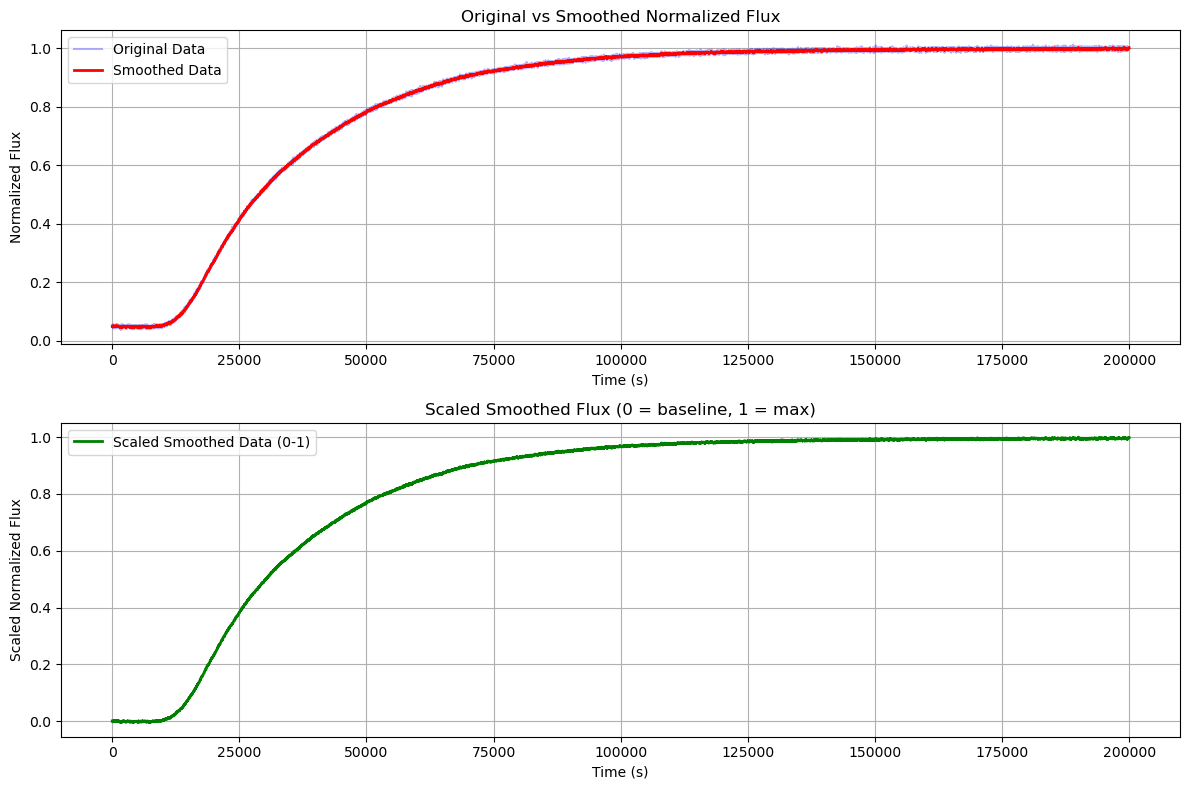

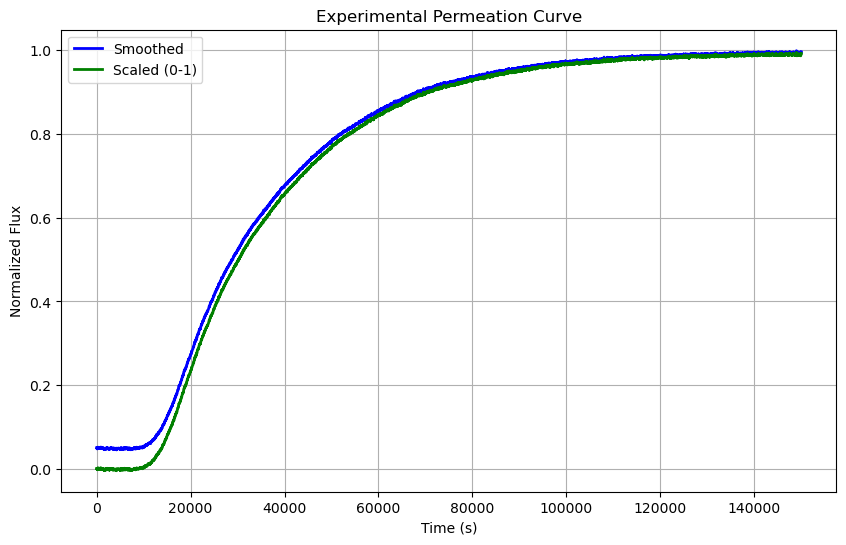

Using 300 points for fitting (from original 15000 points)


In [37]:
# Load and preprocess experimental data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load experimental data
exp_data = pd.read_excel('../data/single_pressure/S4R3.xlsx')
print(f"Number of rows: {len(exp_data)}")

# Calculate flux from experimental measurements
d = 1  # membrane diameter [cm]
area = d**2 * np.pi  # membrane area [cm²]
q = 10  # flow rate [cm³/min]
exp_data['flux'] = exp_data['yCO2'] * q / area * 60  # [cm³/s/cm²]
exp_data['normalised_flux'] = exp_data['flux'] / exp_data['flux'].rolling(window=100).mean().max()

# Smooth out the normalized flux data with a rolling window
window_size = 10
exp_data['smoothed_norm_flux'] = exp_data['normalised_flux'].rolling(window=window_size, center=True).mean()

# Fill NaN values at the beginning and end of the smoothed data
exp_data['smoothed_norm_flux'] = exp_data['smoothed_norm_flux'].fillna(method='bfill').fillna(method='ffill')

# Create a scaled version that starts at 0
baseline = exp_data['smoothed_norm_flux'].iloc[:100].mean()  # Use first 100 points as baseline
max_value = exp_data['smoothed_norm_flux'].max()
exp_data['scaled_smoothed_norm_flux'] = (exp_data['smoothed_norm_flux'] - baseline) / (max_value - baseline)

# Plot the original, smoothed, and scaled data
plt.figure(figsize=(12, 8))

# Original vs smoothed
plt.subplot(2, 1, 1)
plt.plot(exp_data['time'], exp_data['normalised_flux'], 'b-', alpha=0.3, label='Original Data')
plt.plot(exp_data['time'], exp_data['smoothed_norm_flux'], 'r-', linewidth=2, label='Smoothed Data')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Flux')
plt.title('Original vs Smoothed Normalized Flux')
plt.legend()
plt.grid(True)

# Scaled smoothed data
plt.subplot(2, 1, 2)
plt.plot(exp_data['time'], exp_data['scaled_smoothed_norm_flux'], 'g-', linewidth=2, label='Scaled Smoothed Data (0-1)')
plt.xlabel('Time (s)')
plt.ylabel('Scaled Normalized Flux')
plt.title('Scaled Smoothed Flux (0 = baseline, 1 = max)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Limit the time range for analysis
exp_data = exp_data.loc[exp_data['time'] < 150e3]

# Plot the final normalized flux data
plt.figure(figsize=(10, 6))
plt.plot(exp_data['time'], exp_data['smoothed_norm_flux'], 'b-', linewidth=2, label='Smoothed')
plt.plot(exp_data['time'], exp_data['scaled_smoothed_norm_flux'], 'g-', linewidth=2, label='Scaled (0-1)')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Flux')
plt.title('Experimental Permeation Curve')
plt.grid(True)
plt.legend()
plt.show()

# Prepare data for model fitting - create a subset with fewer points for efficiency
# Take every Nth point to reduce computation time in fitting
n_skip = 50  # adjust as needed for balance between accuracy and speed
fit_data = exp_data.iloc[::n_skip].copy()
print(f"Using {len(fit_data)} points for fitting (from original {len(exp_data)} points)")

Starting multi-start optimization with 3 initial points...

Trial 1/3
Initial guess: Beta=2.0, Eta=0.1, D0=1.00e-08
Beta: 2.0000, Eta: 0.1000, D0: 1.00e-08 - RMSE: 0.811643
Beta: 2.0000, Eta: 0.1000, D0: 1.00e-08 - RMSE: 0.811643
Beta: 2.0000, Eta: 0.1000, D0: 1.00e-08 - RMSE: 0.811643
Beta: 2.0000, Eta: 0.1000, D0: 2.00e-08 - RMSE: 0.809576
Beta: 2.0000, Eta: 0.1000, D0: 1.00e-02 - RMSE: 0.410286
Beta: 2.0000, Eta: 0.1000, D0: 1.00e-02 - RMSE: 0.410286
Beta: 2.0000, Eta: 0.1000, D0: 1.00e-02 - RMSE: 0.410286
Beta: 2.0000, Eta: 0.1000, D0: 1.00e-02 - RMSE: 0.410286
Beta: 2.0000, Eta: 0.1000, D0: 3.33e-03 - RMSE: 0.410286
Beta: 2.0000, Eta: 0.1000, D0: 3.33e-03 - RMSE: 0.410286
Beta: 2.0000, Eta: 0.1000, D0: 3.33e-03 - RMSE: 0.410286
Beta: 2.0000, Eta: 0.1000, D0: 3.33e-03 - RMSE: 0.410286
Beta: 2.0000, Eta: 0.1000, D0: 1.11e-03 - RMSE: 0.410286
Beta: 2.0000, Eta: 0.1000, D0: 1.11e-03 - RMSE: 0.410286
Beta: 2.0000, Eta: 0.1000, D0: 1.11e-03 - RMSE: 0.410286
Beta: 2.0000, Eta: 0.1000, D0

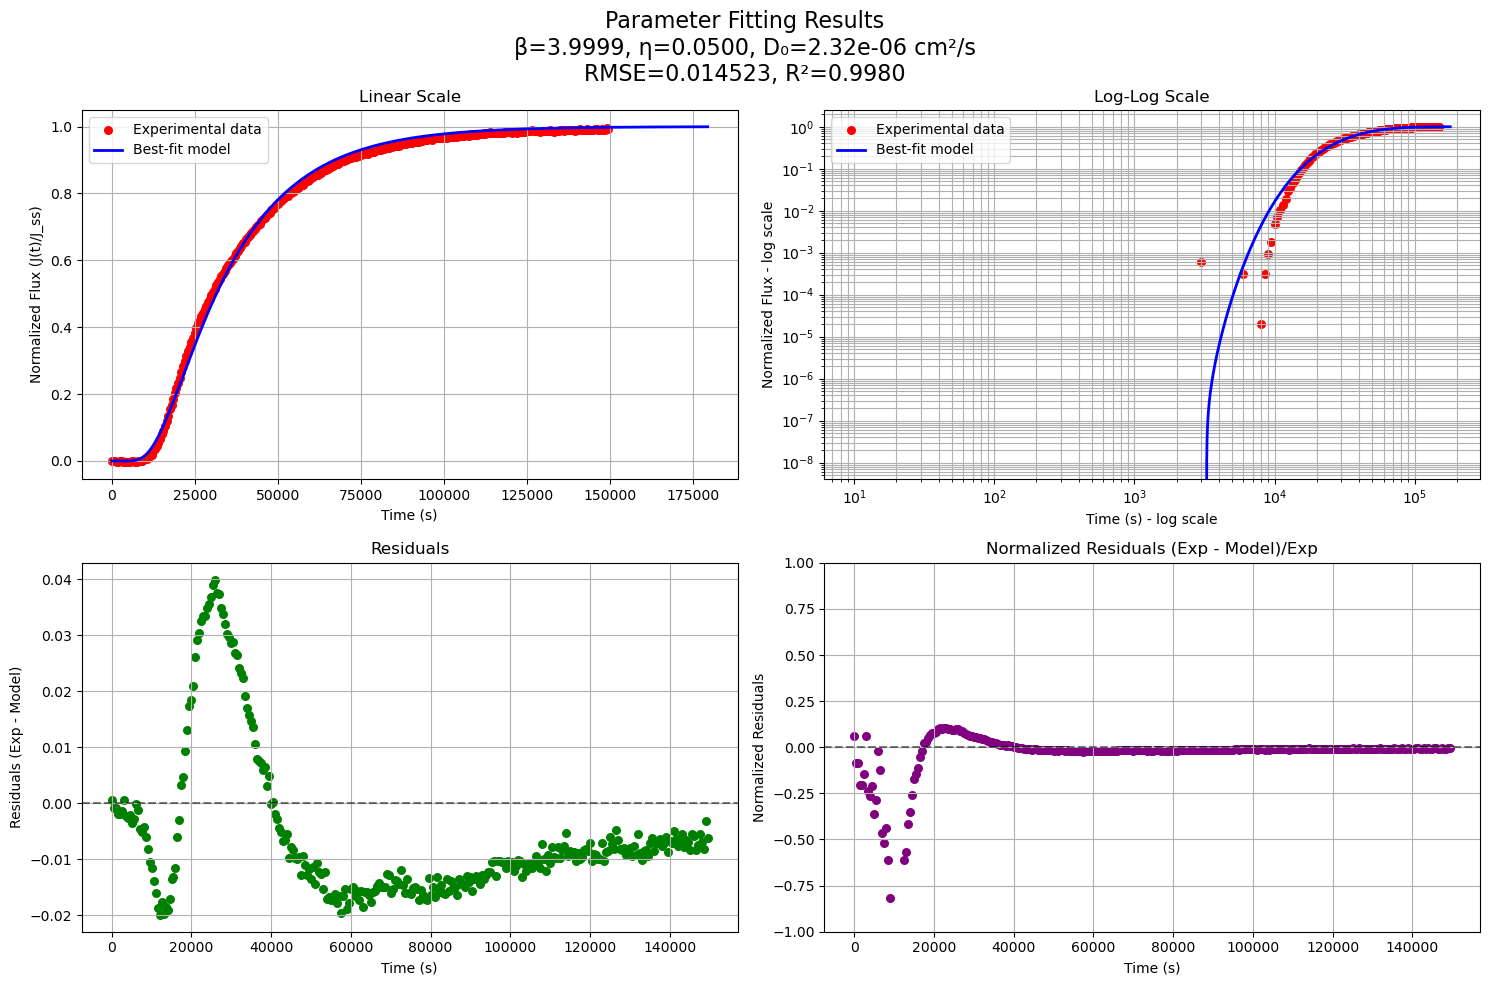

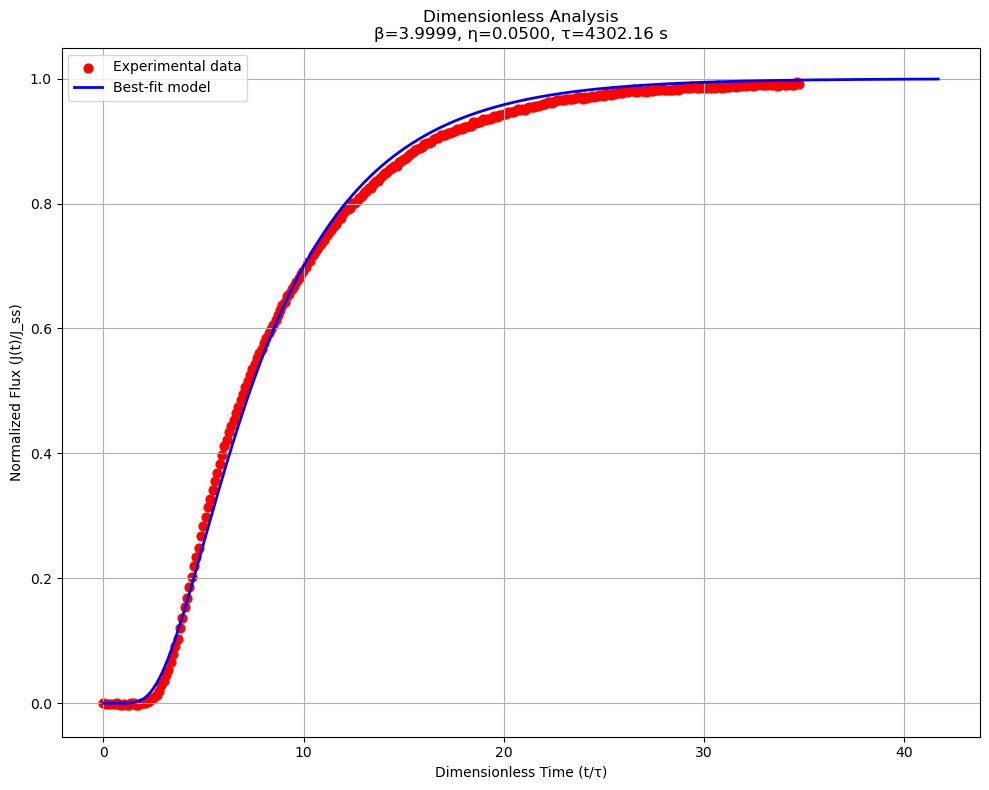


Fitting Results:
Best-fit parameters: β=3.9999, η=0.0500, D₀=2.32e-06 cm²/s
RMSE: 0.014523
R²: 0.9980
Characteristic time (τ): 4302.16 s
Time to reach 99% of steady state: 117070.00 s (27.21 τ)
Iterations for best fit: 5
Function evaluations for best fit: 200
Success: True
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Best-fit parameters:
β = 3.999942878963211
η = 0.05004587048457138
D₀ = 2.3244135721174723e-06 cm²/s
R² = 0.9980090987053749


In [43]:
# Example usage with time and normalized_flux directly
# Define several starting points to try
initial_guesses = [
    {'beta': 2.0, 'eta': 0.1, 'D0': 1e-8},    # First guess
    {'beta': 1.0, 'eta': 0.5, 'D0': 1e-7},    # Second guess
    {'beta': 4.0, 'eta': 0.05, 'D0': 1e-6}    # Third guess
]

# Define bounds for parameter search
bounds = {
    'beta': (1e-5, 100.0),     # Range for beta
    'eta': (1e-5, 100.0),      # Range for eta
    'D0': (1e-10, 1e-2)       # Range for D0 (cm²/s)
}

# If your data is in a DataFrame
time_values = fit_data['time']         # Your time column 
flux_values = fit_data['scaled_smoothed_norm_flux']         # Your normalized flux column

# Run the fitting with multiple starting points
best_params, fit_results = fit_permeation_parameters(
    time=time_values,                  # Time values in seconds
    normalised_flux=flux_values,       # Normalized flux values (J(t)/J_ss)
    L=0.1,                             # Membrane thickness in cm
    initial_guesses=initial_guesses,   # List of starting points to try
    bounds=bounds,                     
    max_iter=100                        # Max iterations per starting point
)

# Print the best-fit parameters and metrics
print("Best-fit parameters:")
print(f"β = {best_params['beta']}")
print(f"η = {best_params['eta']}")
print(f"D₀ = {best_params['D0']} cm²/s")
print(f"R² = {fit_results['r2']}")

In [35]:
def compare_model_exp(time, norm_flux, eta, beta, D0, L=0.1, display_plot=True):
    """
    Compare experimental permeation data with model predictions for specified parameters.
    
    Parameters:
    -----------
    time : array-like
        Time values of experimental data (seconds)
    norm_flux : array-like
        Normalized flux values of experimental data
    eta : float
        Parameter in dimensionless diffusivity formula
    beta : float
        Parameter in dimensionless diffusivity formula
    D0 : float
        Characteristic diffusivity (cm²/s)
    L : float, optional
        Membrane thickness (cm), default 0.1 cm
    display_plot : bool, optional
        Whether to display the plot (default: True)
        
    Returns:
    --------
    tuple
        (model_flux_df, experimental_data) containing the model results and experimental data
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    
    # Convert inputs to numpy arrays if they aren't already
    time_array = np.array(time)
    flux_array = np.array(norm_flux)
    
    # Get the maximum time from the experimental data (add 10% margin)
    T_max = 1.1 * np.max(time_array)
    
    # Run the model with the specified parameters
    _, flux_df, _, _, _, results = solve_permeation_pde(
        beta=beta, 
        eta=eta, 
        D0=D0, 
        L=L, 
        T=T_max, 
        dx=0.05,
        verbose=False,
        display_plot=False
    )
    
    # Create a DataFrame with the experimental data for easy comparison
    exp_df = pd.DataFrame({
        'time': time_array,
        'normalized_flux': flux_array
    })
    
    if display_plot:
        # Create the comparison plot
        plt.figure(figsize=(8, 6))
        
        # Plot experimental data
        plt.scatter(time_array, flux_array, s=15, color='blue', alpha=0.3, label='Experimental data')
        
        # Plot model data
        plt.plot(flux_df['time (s)'], flux_df['normalized_flux'], color='red', linewidth=2, 
                 label=f'Model (β={beta}, η={eta}, D₀={D0:.1e} cm²/s)')
        
        # Add annotations for model parameters
        params_text = f"Model Parameters:\nβ = {beta}\nη = {eta}\nD₀ = {D0:.1e} cm²/s\nL = {L} cm"
        plt.annotate(params_text, xy=(0.02, 0.75), xycoords='axes fraction', 
                     bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))
        
        # Label axes and add title
        plt.xlabel('Time (s)', fontsize=12)
        plt.ylabel('Normalized Flux (J(t)/J_ss)', fontsize=12)
        plt.title('Comparison of Experimental and Model Permeation Curves', fontsize=14)
        
        # Add grid and legend
        plt.grid(True, alpha=0.3)
        plt.legend(loc='lower right')
        
        # Log-scale plot as an inset
        ax_inset = plt.axes([0.6, 0.2, 0.35, 0.3])  # [left, bottom, width, height]
        ax_inset.scatter(time_array, flux_array, s=5, color='blue', alpha=0.3)
        ax_inset.plot(flux_df['time (s)'], flux_df['normalized_flux'], color='red', linewidth=1.5)
        ax_inset.set_xscale('log')
        ax_inset.set_yscale('log')
        ax_inset.set_title('Log-Log Scale', fontsize=10)
        ax_inset.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return flux_df, exp_df

C:\Users\sieun\AppData\Local\Temp\ipykernel_21908\4289563466.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


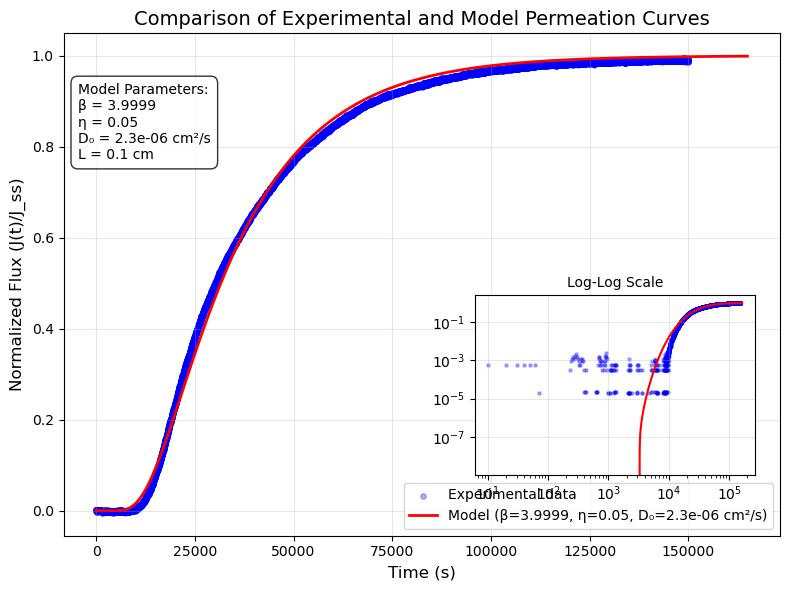

In [42]:
flux_df, exp_df = compare_model_exp(exp_data['time'], exp_data['scaled_smoothed_norm_flux'], beta=3.9999, eta=0.05, D0=2.32e-06)